In [51]:
""" A lot of the functions defined are from the OSISoft repository:
    https://github.com/osisoft/OSI-Samples-PI-System/tree/master/piwebapi_samples/Python
"""

import json
import getpass
import requests
import urllib3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas.io.json import json_normalize
urllib3.disable_warnings()

OSI_AF_ATTRIBUTE_TAG = 'Density'
OSI_AF_DATABASE = 'GEM Diamonds'
OSI_AF_ELEMENT = 'GEM Diamonds\\Production Operations\\Lesotho\\Letseng\\Plant 1\\DMS\\Coarse DMS\\Coarse Correct Medium Pump Density PID Controller'



In [52]:
def call_headers(include_content_type):
    """ Create API call headers
        @includeContentType boolean:  flag determines whether or not the
        content-type header is included
    """
    if include_content_type is True:
        header = {
            'content-type': 'application/json',
            'X-Requested-With': 'XmlHttpRequest'
        }
    else:
        header = {
            'X-Requested-With': 'XmlHttpRequest'
        }

    return header

In [53]:
def call_security_method(security_method, user_name, user_password):
    """ Create API call security method
        @param security_method string:  security method to use:  basic or kerberos
        @param user_name string: The user's credentials name
        @param user_password string: The user's credentials password
    """
    from requests.auth import HTTPBasicAuth
    from requests_kerberos import HTTPKerberosAuth

    if security_method.lower() == 'basic':
        security_auth = HTTPBasicAuth(user_name, user_password)
    else:
        security_auth = HTTPKerberosAuth(mutual_authentication='REQUIRED',
                                         sanitize_mutual_error_response=False)

    return security_auth

In [54]:
def read_attribute_snapshot(piwebapi_url, asset_server, user_name, user_password,
                            piwebapi_security_method):
    """ Read a single value
        @param piwebapi_url string: the URL of the PI Web API
        @param asset_server string:  Name of the Asset Server
        @param user_name string: The user's credentials name
        @param user_password string: The user's credentials password
        @param piwebapi_security_method string:  Security method:  basic or kerberos
    """
    print('readAttributeSnapshot')

    #  create security method - basic or kerberos
    security_method = call_security_method(
        piwebapi_security_method, user_name, user_password)

    #  Get the sample tag
    request_url = '{}/attributes?path=\\\\{}\\{}\\{}|{}'.format(
        piwebapi_url, asset_server, OSI_AF_DATABASE, OSI_AF_ELEMENT, OSI_AF_ATTRIBUTE_TAG)
    response = requests.get(request_url, auth=security_method, verify=False)

    #  Only continue if the first request was successful
    if response.status_code == 200:
    #   print(response.text)
        #  Deserialize the JSON Response
        data = json.loads(response.text)

        #  Read the single stream value
        response = requests.get(piwebapi_url + '/streams/' + data['WebId'] + '/value',
                                auth=security_method, verify=False)

        if response.status_code == 200:
            print('{} Snapshot Value'.format(OSI_AF_ATTRIBUTE_TAG))
            print(json.dumps(json.loads(response.text), indent=4, sort_keys=True))
        else:
            print(response.status_code, response.reason, response.text)
    else:
        print(response.status_code, response.reason, response.text)
    return response.status_code

In [55]:
def do_batch_call(piwebapiurl, asset_server, user_name, user_password, piwebapi_security_method):
    """ Create and execute a PI Web API batch call
    Parameters:
        piwebapiurl: the URL of the PI Web API
        assetServer:  the AF server name
        user_name:  User's credentials name
        user_password:  User's credentials password
        piwebapi_security_method:  Security method:  basic or kerberos
    """
    print('doBatchCall')

    #  create security method - basic or kerberos
    security_method = call_security_method(
        piwebapi_security_method, user_name, user_password)

    #  Get the sample tag
    request_url = '{}/attributes?path=\\\\{}\\{}\\{}|{}'.format(
        piwebapiurl, asset_server, OSI_AF_DATABASE, OSI_AF_ELEMENT, OSI_AF_ATTRIBUTE_TAG)
    response = requests.get(request_url, auth=security_method, verify=False)

    #  Only continue if the first request was successful
    if response.status_code == 200:
        #  Deserialize the JSON Response
        data = json.loads(response.text)

        #  Create the header
        header = call_headers(False)
       
        #  Create the data for this call
        batch_request = {
            '1': {
                'Method': 'GET',
                'Resource': request_url,
                'Content': '{}'
              },
            '6': {
                'Method': 'GET',
                'Resource': piwebapiurl + '/streams/{0}/recorded?maxCount=20&selectedFields=Items.Timestamp;Items.Value',
                'Content': '{}',
                'Parameters': ['$.1.Content.WebId'],
                'ParentIds': ['1']
            }
        }

        #  Now that we have the attribute, we need to read the stream value
        response = requests.post(piwebapiurl + '/batch', auth=security_method, verify=False,
                                 json=batch_request, headers=header)

        if response.status_code == 207:
            print('Batch Status: ' + str(response.status_code))

            #  Deserialize the JSON Response
            data = json.loads(response.text)

            print(
                '6: Get the sample tag\'s last 20 recorded values as the function result')
            #print(json.dumps(data['6'], indent=4, sort_keys=True))
        
           # data

        else:
            print(response.status_code, response.reason, response.text)
    else:
        print(response.status_code, response.reason, response.text)

    return data['6']

In [56]:
" Main method.  Receive user input and call the write value methods """
piwebapi_url ='https://srvletpivision.letmoms.local:8080/piwebapi/'
af_server_name = 'srvletpiaf'
piwebapi_user = str(input('Enter the user name (domain\\username): ')) ##'minerals\\matthew.fry'
piwebapi_password = str(getpass.getpass('Enter the password: ')) 
piwebapi_security_method = 'Kerberos'
    
piwebapi_security_method = piwebapi_security_method.lower()

read_attribute_snapshot(piwebapi_url, af_server_name, piwebapi_user, piwebapi_password,
                            piwebapi_security_method)

temp=do_batch_call(piwebapi_url, af_server_name, piwebapi_user, piwebapi_password,
                            piwebapi_security_method)



Enter the user name (domain\username): minerals\\matthew.fry
Enter the password: ········
readAttributeSnapshot
Density Snapshot Value
{
    "Annotated": false,
    "Good": true,
    "Questionable": false,
    "Substituted": false,
    "Timestamp": "2020-04-21T10:52:50.3020782Z",
    "UnitsAbbreviation": "kg/L",
    "Value": 2.0
}
doBatchCall
Batch Status: 207
6: Get the sample tag's last 20 recorded values as the function result


In [57]:
temp2=temp['Content']
temp3 =temp2['Items']
df=json_normalize(temp3)

In [58]:
#adhust to SA time
import datetime
df['Timestamp']=  pd.to_datetime(df['Timestamp'], format='%Y %m %dT%H:%M:%S.%f')
df['Timestamp']=df['Timestamp'].dt.tz_convert('Africa/Johannesburg')
type(df.iloc[0,0])

pandas._libs.tslibs.timestamps.Timestamp

In [59]:
df.iloc[0,0]

Timestamp('2020-04-20 13:01:59.484130800+0200', tz='Africa/Johannesburg')

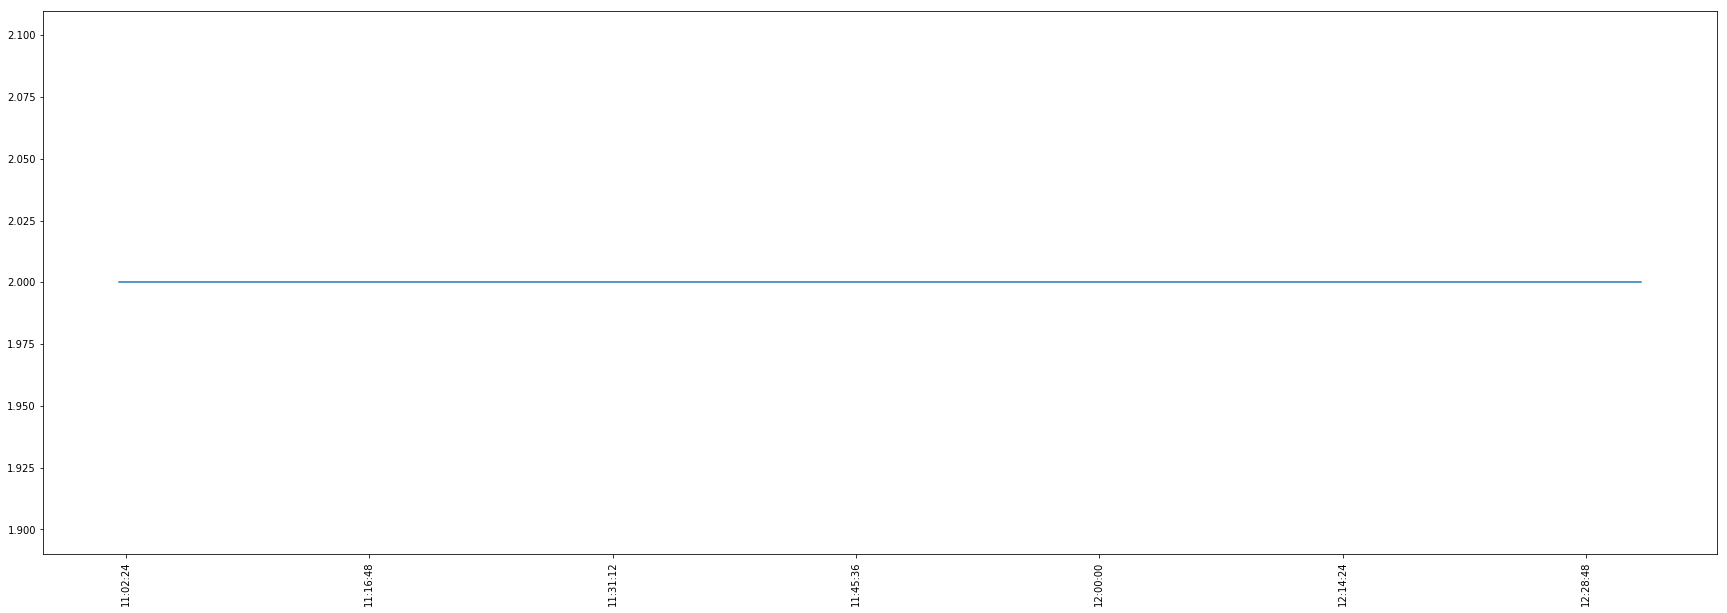

In [60]:
import matplotlib.dates as mdates

dates=mdates.date2num(df['Timestamp'])
myFmt = mdates.DateFormatter('%H:%M:%S')
fig, ax = plt.subplots(figsize=(30, 10))
plt.plot(dates,df['Value'])
plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(myFmt)
plt.show()


In [61]:
df

,Timestamp,Value
0,2020-04-20 13:01:59.484130800+02:00,2.0
1,2020-04-20 13:02:00.499755800+02:00,2.0
2,2020-04-20 13:11:59.501159600+02:00,2.0
3,2020-04-20 13:12:00.516784600+02:00,2.0
4,2020-04-20 13:21:59.502227700+02:00,2.0
5,2020-04-20 13:22:00.517852700+02:00,2.0
6,2020-04-20 13:31:59.503067+02:00,2.0
7,2020-04-20 13:32:00.518692+02:00,2.0
8,2020-04-20 13:41:59.503707800+02:00,2.0
9,2020-04-20 13:42:00.519332800+02:00,2.0
